In [1]:
import argparse
import dynamo as dyn
import scanpy as sc
import gc
from pathlib import Path
import warnings
import utils
import importlib
import pandas as pd
import anndata as ad
import mygene
import scvelo as scv
import numpy as np
importlib.reload(utils)
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
dyn.configuration.set_figure_params('dynamo', background='white')
dyn.get_all_dependencies_version()
%load_ext autoreload
%autoreload 2

package,mudata,umap-learn,pynndescent,numdifftools,leidenalg,igraph,seaborn,statsmodels,numba,session-info,dynamo-release,scipy,pandas,loompy,colorcet,openpyxl,networkx,matplotlib,pre-commit,typing-extensions,tqdm,setuptools
version,0.2.3,0.5.7,0.5.13,0.9.41,0.10.2,0.11.8,0.13.2,0.14.4,0.61.0,1.0.0,1.4.2rc1,1.15.2,2.2.3,3.0.8,3.1.0,3.1.5,3.4.2,3.10.0,4.1.0,4.12.2,4.62.3,59.5.0


In [2]:
DATA_DIR = Path("/root/autodl-tmp/dataset") 
DATASET = "labeled_organoid"
K_FOLD = 3
CLUSTER_KEY = 'cell_type'
SEED = 1234

In [3]:
(DATA_DIR / DATASET / "raw").mkdir(parents=True, exist_ok=True)
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

In [4]:
adata = sc.read(DATA_DIR / DATASET / "raw" / "labeled_organoid.h5ad")

In [5]:
# mapping:
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
 }

adata.obs[CLUSTER_KEY] = adata.obs.som_cluster_id.map(cell_mapper).astype('str')

In [6]:
adata.obs.time = adata.obs.time.astype('str')
adata.obs.loc[adata.obs['time'] == 'dmso', 'time'] = -1
adata.obs['time'] = adata.obs['time'].astype(float)
adata = adata[adata.obs.time != -1, :]
adata = adata[adata.obs.exp_type == 'Pulse', :]
adata.layers['new'], adata.layers['total'] = adata.layers['ul'] + adata.layers['sl'], adata.layers['su'] + adata.layers['sl'] + adata.layers['uu'] + adata.layers['ul']
adata.layers['spliced'], adata.layers['unspliced'] = adata.layers['ul'] + adata.layers['uu'], adata.layers['sl'] + adata.layers['su']
del adata.layers['uu'], adata.layers['ul'], adata.layers['su'], adata.layers['sl']

In [7]:
sub_adata_lst = utils.split_anndata_stratified(adata, n_splits=K_FOLD, cluster_key=CLUSTER_KEY)

In [8]:
adata

AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type'
    var: 'ID', 'NAME'
    layers: 'new', 'total', 'spliced', 'unspliced'

In [25]:
sub_adata = adata.copy()
sub_adata.layers['raw_spliced'] = sub_adata.layers['spliced']
sub_adata.layers['raw_unspliced'] = sub_adata.layers['unspliced']
scv.pp.filter_and_normalize(sub_adata, min_shared_counts=20, n_top_genes=2000)
if sub_adata.n_vars < 2000:
    sc.pp.highly_variable_genes(sub_adata, n_top_genes=sub_adata.n_vars, subset=True)
print(sub_adata.n_vars)
if 'X_pca' in sub_adata.obsm:
    del sub_adata.obsm['X_pca']
if 'pca' in sub_adata.uns:
    del sub_adata.uns['pca']
if "neighbors" in sub_adata.uns.keys():
    del sub_adata.uns['neighbors']
scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
utils.fill_in_neighbors_indices(sub_adata)
sc.tl.umap(sub_adata, random_state=SEED)
sub_adata.obs['u_lib_size_raw'] = sub_adata.layers['raw_unspliced'].toarray().sum(-1) 
sub_adata.obs['s_lib_size_raw'] = sub_adata.layers['raw_spliced'].toarray().sum(-1)
if SAVE_DATA:
    sub_adata.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_full.h5ad")
del sub_adata
gc.collect()

for i in range(K_FOLD):
    sub_adata = sub_adata_lst[i].copy()
    sub_adata.layers['raw_spliced'] = sub_adata.layers['spliced']
    sub_adata.layers['raw_unspliced'] = sub_adata.layers['unspliced']
    scv.pp.filter_and_normalize(sub_adata, min_shared_counts=20, n_top_genes=2000)
    if sub_adata.n_vars < 2000:
        sc.pp.highly_variable_genes(sub_adata, n_top_genes=sub_adata.n_vars, subset=True)
    print(sub_adata.n_vars)
    if 'X_pca' in sub_adata.obsm:
        del sub_adata.obsm['X_pca']
    if 'pca' in sub_adata.uns:
        del sub_adata.uns['pca']
    if "neighbors" in sub_adata.uns.keys():
        del sub_adata.uns['neighbors']
    scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
    utils.fill_in_neighbors_indices(sub_adata)
    sc.tl.umap(sub_adata, random_state=SEED)
    sub_adata.obs['u_lib_size_raw'] = sub_adata.layers['raw_unspliced'].toarray().sum(-1) 
    sub_adata.obs['s_lib_size_raw'] = sub_adata.layers['raw_spliced'].toarray().sum(-1)
    if SAVE_DATA:
        sub_adata.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_{i}.h5ad")
    del sub_adata
    gc.collect()

Filtered out 5492 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
2000


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_1002/3635165470.py:14: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be remove

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Normalized count data: total, new.


NameError: name 'get_n_neighs' is not defined

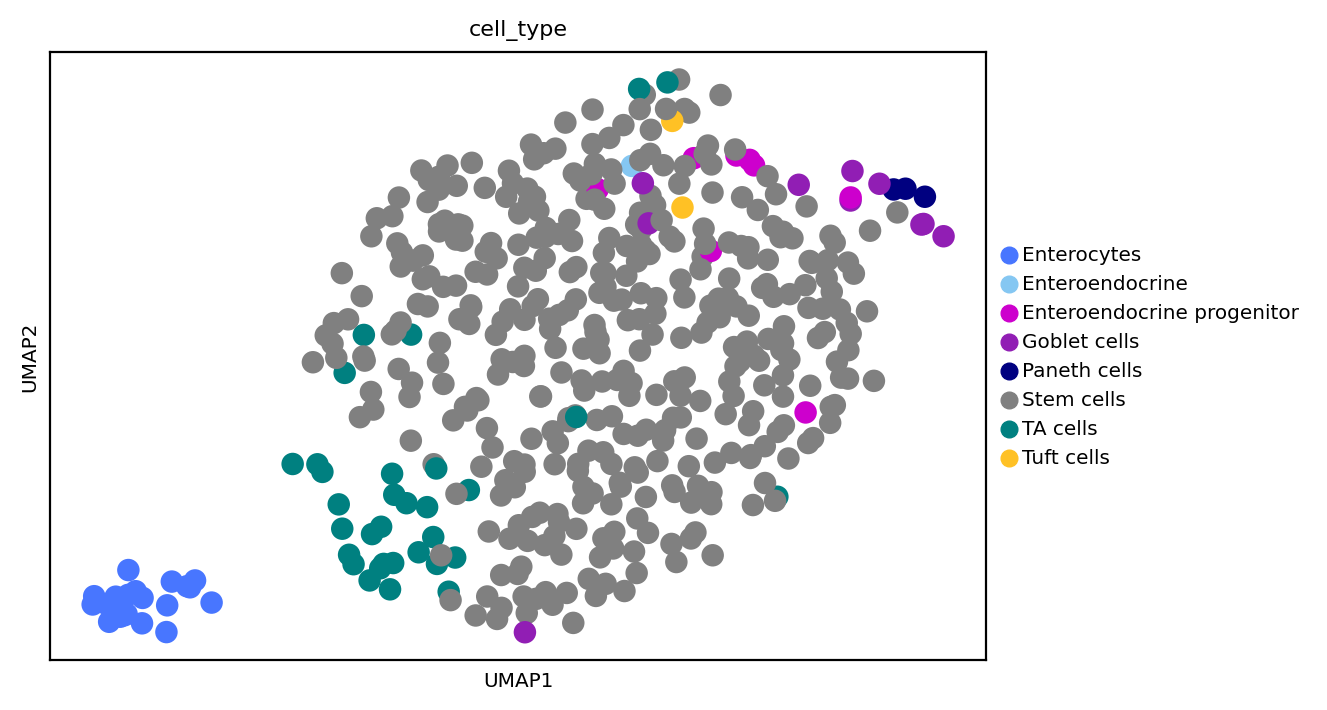

In [9]:
sub_adata = sc.read(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_0.h5ad")
sc.pl.umap(sub_adata,color='cell_type')